This will explore how importance scores from three different methods compare on simulated data.

The simulated data was as follows:
- 1/3rd sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 1,0,0
- 1/3rd sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,1,0
- 1/3rd sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

First, we generate data to analyze. Let's make datasets with the same distribution of motifs as the data that the model was trained on (the model was not trained on this exact data)

In [1]:
%matplotlib inline

In [2]:
#Generate the data. Will install the simdna package if necessary.
try:
    import simdna
except ImportError, e:
    print("installing simdna package")
    !pip install git+git://github.com/kundajelab/simdna.git

#This will produce a warning about embedding a TAL1_known1 motif, which is normal
!./generate_data.sh

Read in the data

In [3]:
import simdna.synthetic as synthetic
tal_gata_filename = "DensityEmbedding_prefix-talgata_motifs-GATA_disc1+TAL1_known1_min-1_max-3_mean-2_zeroProb-0_seqLength-200_numSeqs-1000.simdata.gz"
#read in the data
tal_gata_data = synthetic.read_simdata_file(tal_gata_filename)

Load the keras model and convert the models to the importance-scoring format. We will compare methods of deeplift, gradient\*input and guided backprop\*input.

In [4]:
import deeplift
import deeplift.conversion.keras_conversion as kc
import numpy as np
from deeplift.blobs import MxtsMode
import keras

#load the keras model
#at the time of writing, this uses keras 0.3 and theano dimension ordering
keras_model_weights = "record_5_model_EKIIu_modelWeights.h5"
keras_model_yaml = "record_5_model_EKIIu_modelYaml.yaml"

#keras_model_weights = "record_7_model_khP5H_modelWeights.h5"
#keras_model_yaml = "record_7_model_khP5H_modelYaml.yaml"


keras_model = kc.load_keras_model(weights=keras_model_weights,
                                  yaml=keras_model_yaml)

#set the reference to something with gc content of background
default = (np.ones((1,4,200))*np.array([0.27, 0.23, 0.23, 0.27])[None,:,None]).astype('float32')
#default = (np.ones((1,4,200))*np.array([0.25, 0.25, 0.25, 0.25])[None,:,None]).astype('float32')

#make various kinds of importance scoring models
deeplift_model, grad_model, guided_backprop_model,\
guided_backprop_deeplift_model, pos_through_dense_deeplift_model,\
counterbalance_dense_deeplift_model =\
    [kc.convert_graph_model(
        model=keras_model,
        mxts_mode=mxts_mode,
        default=default) for mxts_mode in [
            MxtsMode.DeepLIFT, MxtsMode.Gradient, MxtsMode.GuidedBackprop,
            MxtsMode.GuidedBackpropDeepLIFT, MxtsMode.PosThroughDenseDeepLIFT,
            MxtsMode.CounterBalanceDenseDeepLIFT]]

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
Using Theano backend.
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


One-hot encode the sequence data

In [5]:
#install the avutils package if it isn't installed
try:
    import avutils
except ImportError, e:
    print("installing avutils package")
    !pip install git+git://github.com/kundajelab/avutils.git

import avutils
import avutils.util

#get one-hot encoded sequence for the tal_gata data
tal_gata_onehot = np.array([avutils.util.seq_to_2d_image(seq) for seq in tal_gata_data.sequences])

In [6]:
deeplift_model.get_name_to_blob()

OrderedDict([('sequence',
              <deeplift.blobs.core.Input_FixedDefault at 0x1096cb810>),
             ('conv1', <deeplift.blobs.convolution.Conv2D at 0x121fa7410>),
             ('conv1_act', <deeplift.blobs.activations.ReLU at 0x121fa7450>),
             ('conv2', <deeplift.blobs.convolution.Conv2D at 0x121fa7490>),
             ('conv2_act', <deeplift.blobs.activations.ReLU at 0x121fa74d0>),
             ('max_pool',
              <deeplift.blobs.convolution.AvgPool2D at 0x121fa7510>),
             ('flatten', <deeplift.blobs.convolution.Flatten at 0x121fa7550>),
             ('dense1', <deeplift.blobs.core.Dense at 0x121fa7590>),
             ('dense1_act', <deeplift.blobs.activations.ReLU at 0x121fa75d0>),
             ('output_preact', <deeplift.blobs.core.Dense at 0x121fa7610>),
             ('output_act',
              <deeplift.blobs.activations.Sigmoid at 0x121fa7650>)])

Double-check that the conversion happened correctly by making sure both the original keras model and the converted models are giving the same predictions (this is not strictly necessary for computing importance scores)

In [7]:
#make sure predictions are the same as the original model
from deeplift import backend as B
deeplift_prediction_func = B.function([deeplift_model.get_name_to_blob()['sequence'].get_activation_vars()],
                                       deeplift_model.get_name_to_blob()['output_act'].get_activation_vars())
original_model_predictions = keras_model.predict({'sequence':tal_gata_onehot}, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[tal_gata_onehot],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions['output'])) < 10**-5
tal_gata_predictions = converted_model_predictions

Sort the predictions by confidence, for use later

In [8]:
#taldata predictions sorted by confidence
tal_gata_predictions_sorted = sorted(enumerate(tal_gata_predictions), key=lambda x: -x[1][2])

Compute the importance scores using two different methods

In [9]:
#compute the importance scores on the sequences
deeplift_func, grad_times_inp_func,\
guided_backprop_func, guided_backprop_deeplift_func,\
pos_through_dense_deeplift_func, counterbalance_dense_deeplift_func =\
    [model.get_target_contribs_func(find_scores_layer_name="sequence",
                                    pre_activation_target_layer_name="output_preact")
     for model in [deeplift_model, grad_model, guided_backprop_model,
                   guided_backprop_deeplift_model, pos_through_dense_deeplift_model,
                   counterbalance_dense_deeplift_model]]

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
for method_name, score_func in [('deeplift', deeplift_func),
                               ('grad_times_inp', grad_times_inp_func),
                               ('guided_backprop', guided_backprop_func),
                               ('guided_backprop_deeplift', guided_backprop_deeplift_func),
                               ('pos_through_dense_deeplift', pos_through_dense_deeplift_func),
                               ('counterbalance_dense_deeplift', counterbalance_dense_deeplift_func)]:
    method_to_task_to_scores[method_name] = {}
    for task_idx in [0,1,2]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[tal_gata_onehot],
                    batch_size=200,
                    progress_update=None))
        assert scores.shape[2]==4
        scores = np.squeeze(np.sum(scores, axis=2),axis=1)
        method_to_task_to_scores[method_name][task_idx] = scores

In [10]:
motif_locations = {'GATA_disc1':[], 'TAL1_known1':[]}
for embeddings in tal_gata_data.embeddings:
    for motif in motif_locations:
        motif_locations[motif].append([])
    for embedding in embeddings:
        motif_locations[embedding.what.getDescription()][-1]\
                       .append((embedding.startPos, embedding.startPos+len(embedding.what)))

In [11]:
def compile_scores_on_motif_locations_vs_others(scores, valid_locations,
                                                smoothen_function, batch_size=200, progress_update=None):
    scores = smoothen_function(scores, batch_size=batch_size, progress_update=progress_update)
    scores_on_valid_locations = []
    scores_on_other_locations = []
    for scores_single_region,valid_locations_single_region in zip(scores, valid_locations):
        #sort valid locations in order
        sorted_valid_locations = sorted(valid_locations_single_region, key=lambda x: x[0])
        for i in range(len(sorted_valid_locations)):
            prev_end = 0 if i==0 else sorted_valid_locations[i-1][1]
            next_start = (len(scores_single_region)
                          if i==(len(sorted_valid_locations)-1)
                          else sorted_valid_locations[i+1][0])
            scores_on_valid_locations.extend(scores_single_region[
                    sorted_valid_locations[i][0]:sorted_valid_locations[i][1]])
            scores_on_other_locations.extend(scores_single_region[prev_end:sorted_valid_locations[i][0]])
            scores_on_other_locations.extend(scores_single_region[sorted_valid_locations[i][1]:next_start])
    return scores_on_valid_locations, scores_on_other_locations

Task 0
0.913554739041
0.87970524651
0.817064895344
0.827205486346
0.842351997041
0.851114184425


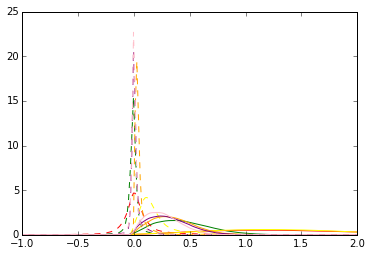

Task 1
0.79574629671
0.687706040752
0.629715127551
0.743447814787
0.75808569541
0.737236061674


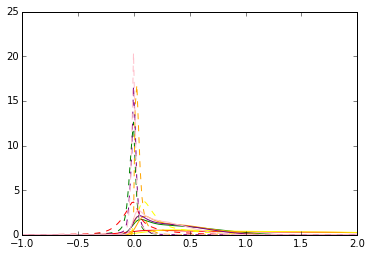

Task 2
0.605179748669
0.503418588772
0.681802770492
0.748379966128
0.763188355542
0.648799934506


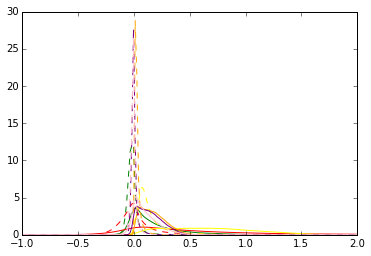

In [12]:
import matplotlib.pyplot as plt
import scipy
import deeplift.util
reload(deeplift.util)
smoothen_window = 7
smoothen_function = deeplift.util.get_smoothen_function(smoothen_window)
for task_idx, motif_locs in [(0, motif_locations['GATA_disc1']),
                                  (1, motif_locations['TAL1_known1']),
                                  (2, [x+y for x,y in zip(motif_locations['GATA_disc1'],
                                                          motif_locations['TAL1_known1'])])]:    
    print("Task "+str(task_idx))
    for method,color in [('deeplift','green'),
                         ('grad_times_inp','red'),
                         ('guided_backprop','yellow'),
                         ('guided_backprop_deeplift','orange'),
                         ('pos_through_dense_deeplift', 'purple'),
                         ('counterbalance_dense_deeplift', 'pink')]:
        scores_on_valid_locations, scores_on_other_locations =\
            compile_scores_on_motif_locations_vs_others(
                method_to_task_to_scores[method][task_idx],
                motif_locs, smoothen_function=smoothen_function)
        from scipy.stats import gaussian_kde
        min_val = min(np.min(scores_on_other_locations),np.min(scores_on_valid_locations))
        max_val = max(np.max(scores_on_other_locations),np.max(scores_on_valid_locations))
        negative_density = gaussian_kde(scores_on_other_locations)
        positive_density = gaussian_kde(scores_on_valid_locations)
        import matplotlib.pyplot as plt
        xs = np.linspace(-1, 2,200)
        plt.plot(xs,negative_density(xs),ls='dashed',color=color)
        plt.plot(xs,positive_density(xs),ls='solid',color=color)
        print(str(scipy.stats.ks_2samp(scores_on_other_locations, scores_on_valid_locations).statistic))
    plt.show()

Visualize the scores at the sequence predicted most confidently. Cyan boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, red boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

[ 0.99913824  0.99393916  0.98161155]
7.90886
deeplift


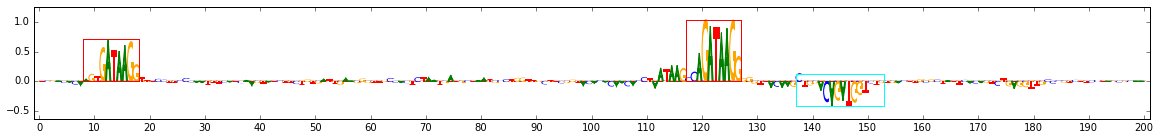

40.7602
grad_times_inp


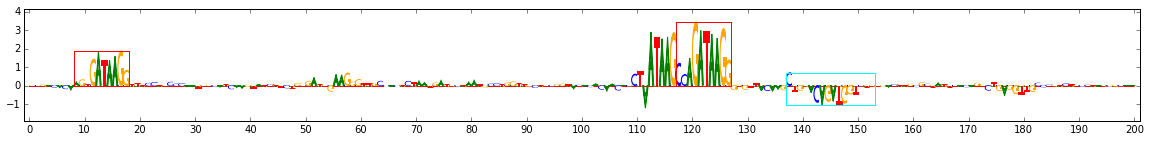

75.3432
guided_backprop


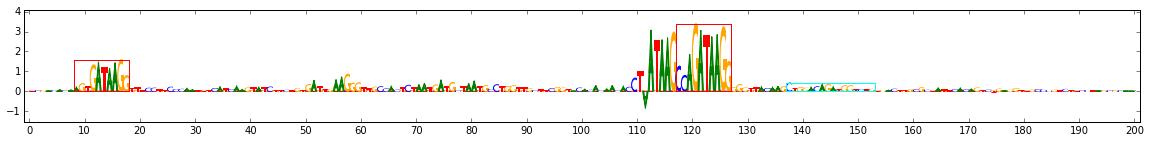

16.1162
guided_backprop_deeplift


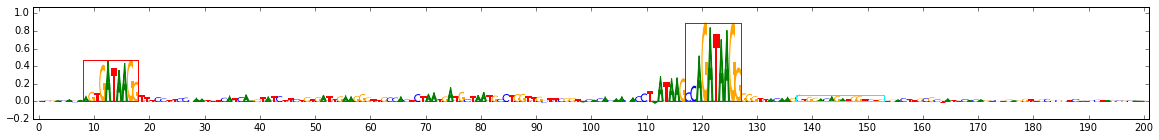

7.65472
pos_through_dense_deeplift


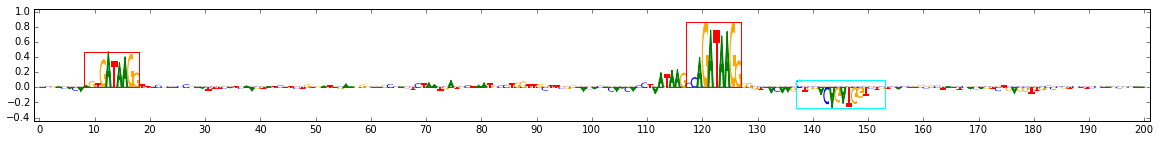

6.74877
counterbalance_dense_deeplift


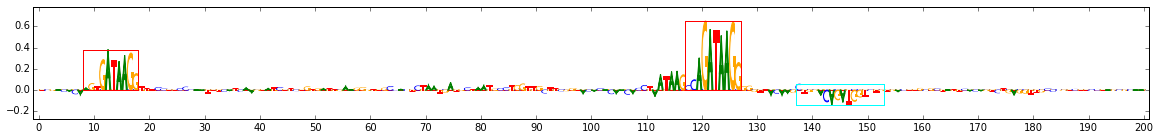

4.42312
deeplift


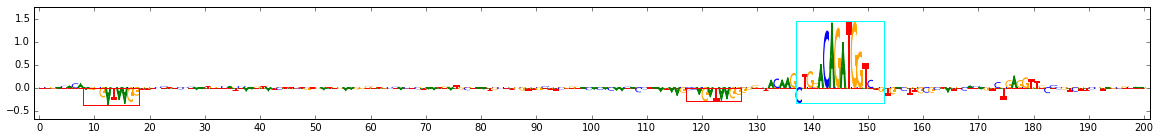

31.7976
grad_times_inp


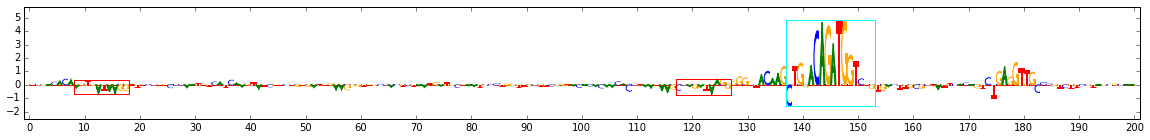

54.6229
guided_backprop


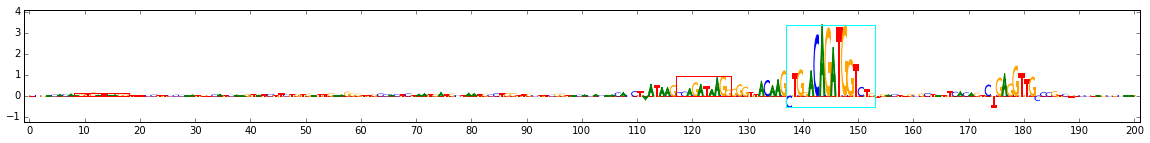

13.0856
guided_backprop_deeplift


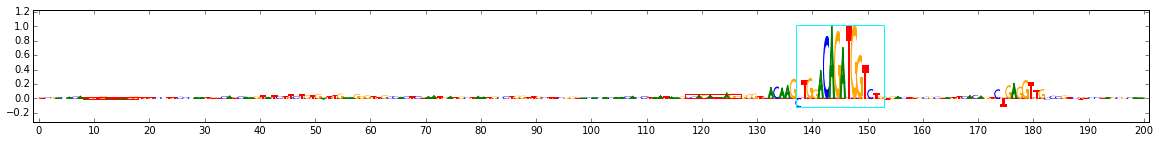

7.20732
pos_through_dense_deeplift


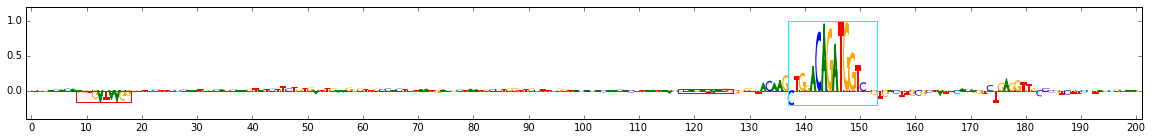

4.97464
counterbalance_dense_deeplift


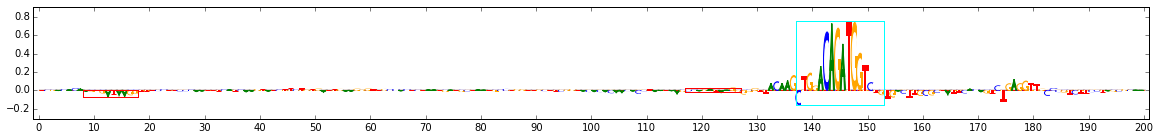

5.78543
deeplift


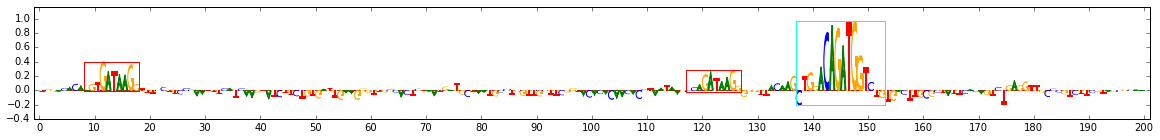

37.3144
grad_times_inp


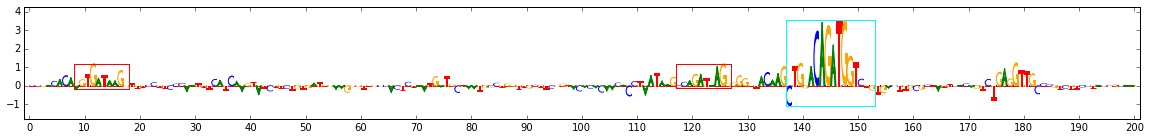

50.932
guided_backprop


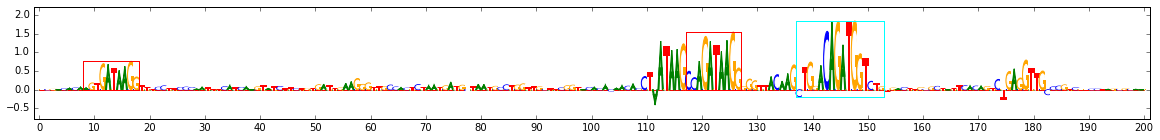

11.2887
guided_backprop_deeplift


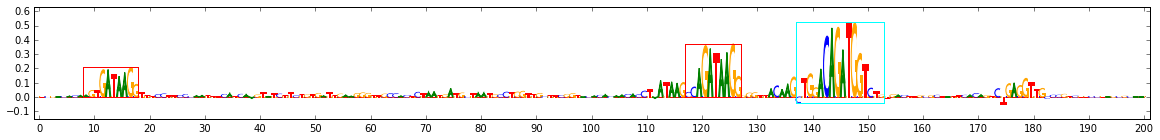

6.96557
pos_through_dense_deeplift


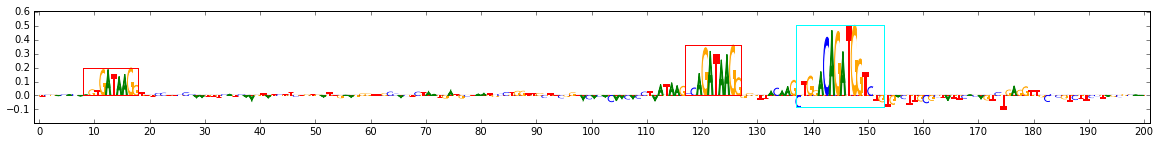

4.13007
counterbalance_dense_deeplift


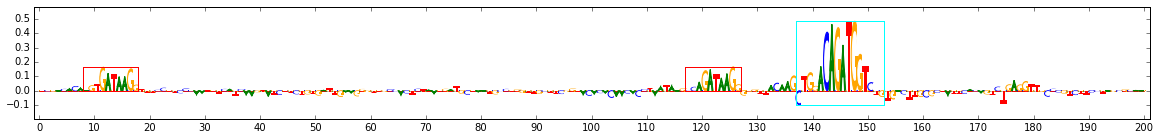

In [13]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence
reload(viz_sequence)

sorted_idx = 500
idx = tal_gata_predictions_sorted[sorted_idx][0]
conf = tal_gata_predictions_sorted[sorted_idx][1]
print(conf)

for task in [0,1,2]:
    for method_name in method_to_task_to_scores:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        print(np.sum(scores_for_idx))
        original_onehot = tal_gata_onehot[idx]
        scores_for_idx = original_onehot*scores_for_idx[None,None,:]
        print(method_name)
        highlight = {'red':motif_locations['GATA_disc1'][idx],
                     'cyan':motif_locations['TAL1_known1'][idx]}
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)

[ 1.          1.          0.99999928]
16.713
deeplift


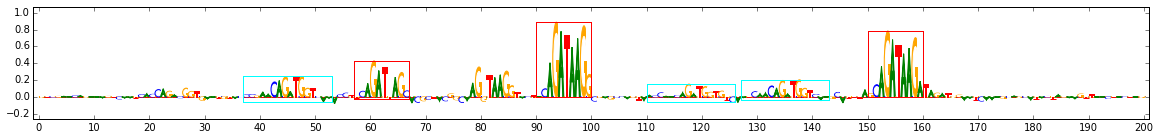

65.3922
grad_times_inp


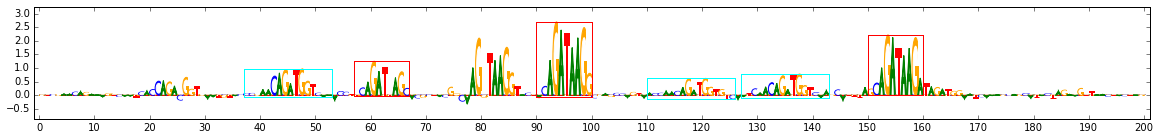

91.9343
guided_backprop


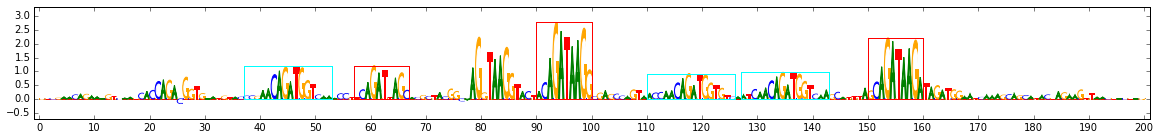

23.6452
guided_backprop_deeplift


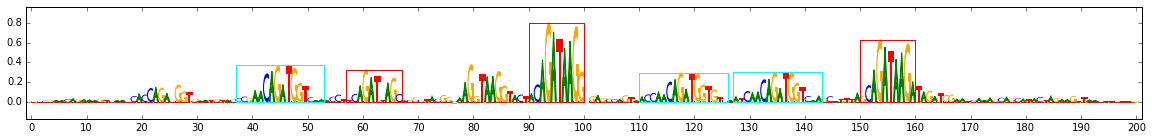

16.5305
pos_through_dense_deeplift


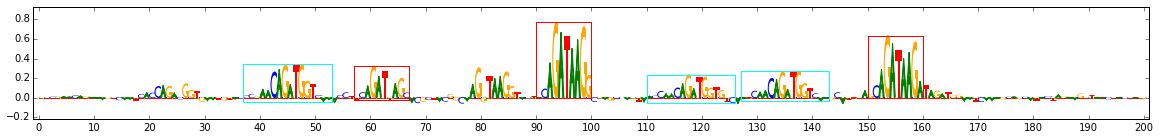

15.7907
counterbalance_dense_deeplift


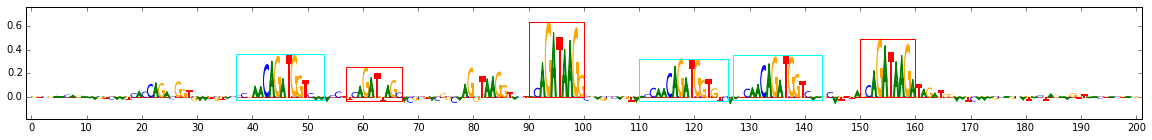

17.3844
deeplift


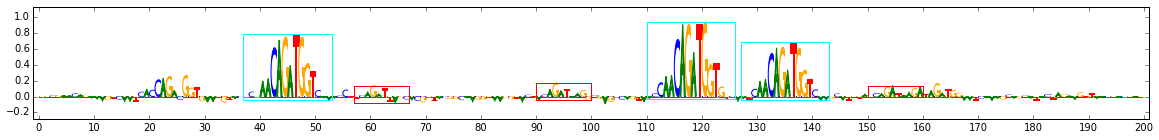

67.3229
grad_times_inp


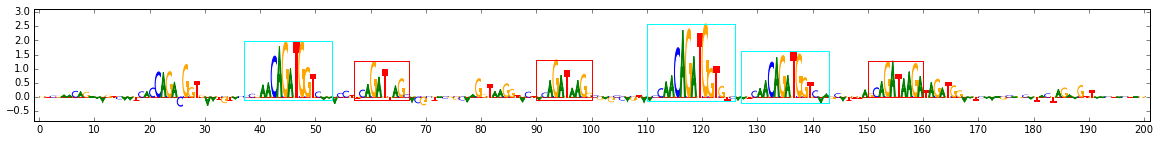

106.722
guided_backprop


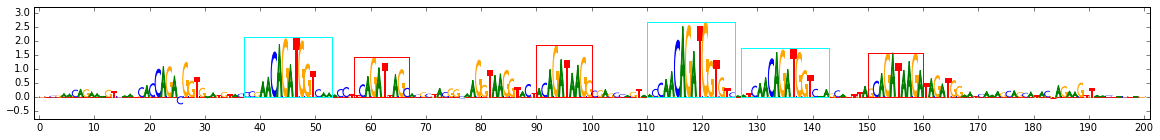

28.4877
guided_backprop_deeplift


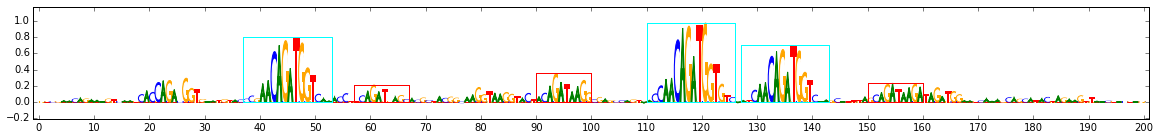

18.6274
pos_through_dense_deeplift


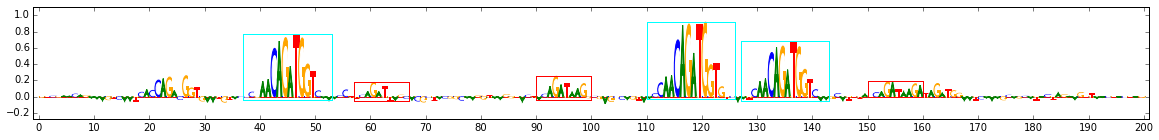

17.9991
counterbalance_dense_deeplift


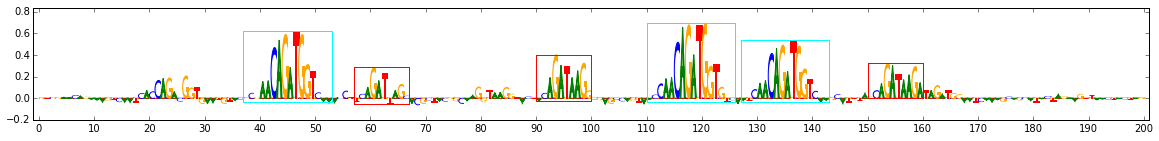

16.0025
deeplift


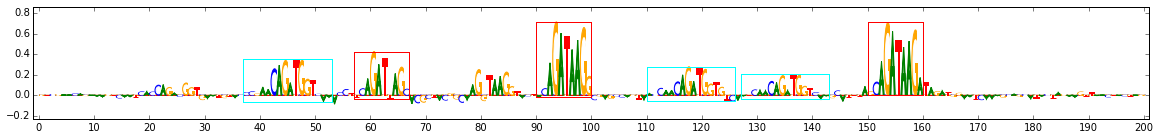

57.2101
grad_times_inp


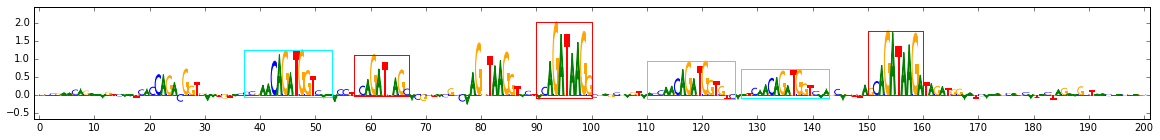

81.4839
guided_backprop


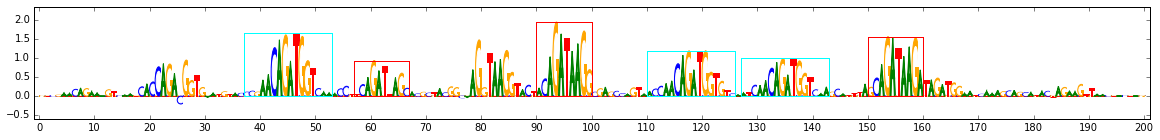

21.8339
guided_backprop_deeplift


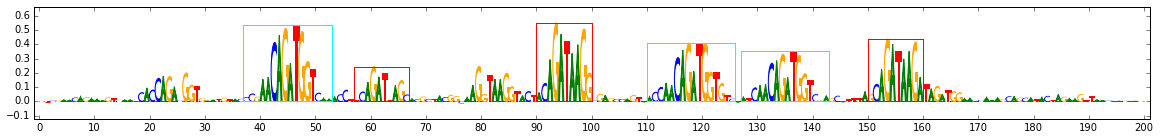

15.2061
pos_through_dense_deeplift


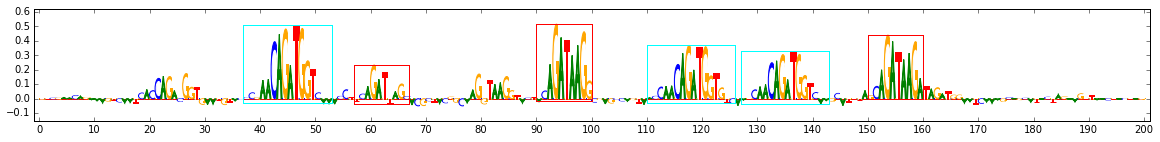

14.185
counterbalance_dense_deeplift


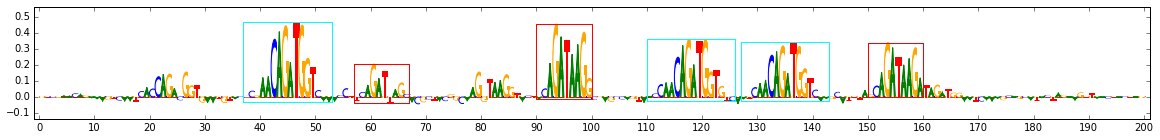

In [14]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence
reload(viz_sequence)

sorted_idx = 2
idx = tal_gata_predictions_sorted[sorted_idx][0]
conf = tal_gata_predictions_sorted[sorted_idx][1]
print(conf)

for task in [0,1,2]:
    for method_name in method_to_task_to_scores:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        print(np.sum(scores_for_idx))
        original_onehot = tal_gata_onehot[idx]
        scores_for_idx = original_onehot*scores_for_idx[None,None,:]
        print(method_name)
        highlight = {'red':motif_locations['GATA_disc1'][idx],
                     'cyan':motif_locations['TAL1_known1'][idx]}
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)